# Customer Segmentation for Personalized Marketing

## Project Overview

This project aims to segment customers based on their shopping behavior using the RFM (Recency, Frequency, Monetary) analysis framework. The goal is to identify distinct customer groups to enable the development of tailored marketing strategies, ultimately improving customer engagement and maximizing revenue.

## Dataset

The dataset used is the **Online Retail II Dataset** from the UCI Machine Learning Repository, publicly available on Kaggle. It contains transactional data for a UK-based online retail store from 2009 to 2011.

* **Source:** [https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci)

## Table of Contents

1.  [Setup & Data Loading](#1.-Setup-&-Data-Loading)
2.  [Data Cleaning & Preprocessing](#2.-Data-Cleaning-&-Pre-processing)
3.  [RFM Feature Engineering](#3.-RFM-Feature-Engineering)
4.  [Exploratory Data Analysis (EDA) on RFM](#4.-Exploratory-Data-Analysis-(EDA)-on-RFM)
5.  [Prepare for Clustering (Handle Skewness & Scale Features)](#5.-Prepare-for-Clustering-(Handle-Skewness-&-Scale-Features))
6.  [Customer Segmentation using K-Means Clustering](#6.-Customer-Segmentation-using-K-Means-Clustering)
7.  [Profile and Characterize Customer Segments](#7.-Profile-and-Characterize-Customer-Segments)
8.  [Formulate Marketing Strategies and Recommendations](#8.-Formulate-Marketing-Strategies-and-Recommendations)

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None) # Display all columns
pd.set_option('display.width', 1000)      # Widen display for better viewing

## 1. Setup & Data Loading

In this section, we set up our Python environment by importing necessary libraries and then load the `online_retail_II.csv` dataset into a pandas DataFrame. We perform an initial inspection to understand its structure, data types, and identify any immediate issues like missing values.

In [2]:
# Load the dataset
df = pd.read_csv('online_retail_II.csv')

# Display the first few rows to confirm it loaded correctly
print("First 5 rows of the dataset:")
print(df.head())

# Get a concise summary of the DataFrame (data types, non-null values)
print("\nDataFrame Information:")
df.info()

First 5 rows of the dataset:
  Invoice StockCode                          Description  Quantity          InvoiceDate  Price  Customer ID         Country
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12  2009-12-01 07:45:00   6.95      13085.0  United Kingdom
1  489434    79323P                   PINK CHERRY LIGHTS        12  2009-12-01 07:45:00   6.75      13085.0  United Kingdom
2  489434    79323W                  WHITE CHERRY LIGHTS        12  2009-12-01 07:45:00   6.75      13085.0  United Kingdom
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48  2009-12-01 07:45:00   2.10      13085.0  United Kingdom
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24  2009-12-01 07:45:00   1.25      13085.0  United Kingdom

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0 

### Initial Observations:

From the `df.info()` output, we can observe:
* The dataset contains **`X` entries** (e.g., 1,067,371 entries).
* **Missing values** are present in the `Description` and, critically, the `Customer ID` columns. The `Customer ID` is essential for customer-level analysis.
* `InvoiceDate` is currently an `object` (string) type and will need to be converted to `datetime` for time-based calculations.
* `Price` and `Customer ID` are `float64`, `Customer ID` should ideally be an integer.

## 2. Data Cleaning & Preprocessing

Data quality is paramount for accurate analysis. In this phase, we address missing values, incorrect data types, duplicate entries, and invalid transactional data (e.g., negative quantities or prices).

### 2.1 Handling Missing `Customer ID`

The `Customer ID` is unique for each customer and vital for RFM analysis. Rows without a `Customer ID` cannot be attributed to a specific customer, so they are removed.

In [3]:
# Check the number of missing Customer IDs before dropping
print(f"Number of missing Customer IDs before dropping: {df['Customer ID'].isnull().sum()}")

# Drop rows where 'Customer ID' is null
df.dropna(subset=['Customer ID'], inplace=True) # inplace=True modifies the DataFrame directly

# Verify that missing Customer IDs are gone
print(f"Number of missing Customer IDs after dropping: {df['Customer ID'].isnull().sum()}")
print(f"New DataFrame shape after dropping Customer ID NaNs: {df.shape}")

Number of missing Customer IDs before dropping: 243007
Number of missing Customer IDs after dropping: 0
New DataFrame shape after dropping Customer ID NaNs: (824364, 8)


In [4]:
# Convert 'Customer ID' to integer type
# Use .astype(int) after ensuring no NaNs are left
df['Customer ID'] = df['Customer ID'].astype(int)

# Verify the data type
print("\nDataFrame Info after converting Customer ID to int:")
df.info()


DataFrame Info after converting Customer ID to int:
<class 'pandas.core.frame.DataFrame'>
Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      824364 non-null  object 
 1   StockCode    824364 non-null  object 
 2   Description  824364 non-null  object 
 3   Quantity     824364 non-null  int64  
 4   InvoiceDate  824364 non-null  object 
 5   Price        824364 non-null  float64
 6   Customer ID  824364 non-null  int32  
 7   Country      824364 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(5)
memory usage: 53.5+ MB


### 2.2 Converting Data Types

We convert `Customer ID` to an integer type for consistency and `InvoiceDate` to a datetime object, which is necessary for time-based calculations like 'Recency'.

In [5]:
# Convert 'InvoiceDate' to datetime objects
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Verify the data type
print("\nDataFrame Info after converting InvoiceDate to datetime:")
df.info()


DataFrame Info after converting InvoiceDate to datetime:
<class 'pandas.core.frame.DataFrame'>
Index: 824364 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      824364 non-null  object        
 1   StockCode    824364 non-null  object        
 2   Description  824364 non-null  object        
 3   Quantity     824364 non-null  int64         
 4   InvoiceDate  824364 non-null  datetime64[ns]
 5   Price        824364 non-null  float64       
 6   Customer ID  824364 non-null  int32         
 7   Country      824364 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1), object(4)
memory usage: 53.5+ MB


### 2.2 Converting Data Types

We convert `Customer ID` to an integer type for consistency and `InvoiceDate` to a datetime object, which is necessary for time-based calculations like 'Recency'.

In [6]:
# Check for duplicate rows
print(f"\nNumber of duplicate rows before dropping: {df.duplicated().sum()}")

# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Verify that duplicates are gone
print(f"Number of duplicate rows after dropping: {df.duplicated().sum()}")
print(f"New DataFrame shape after dropping duplicates: {df.shape}")


Number of duplicate rows before dropping: 26479
Number of duplicate rows after dropping: 0
New DataFrame shape after dropping duplicates: (797885, 8)


### 2.3 Handling Duplicate Rows

Duplicate rows can skew analysis by overrepresenting certain transactions. We identify and remove them to ensure each record is unique.

In [7]:
# Check for invalid Quantity and Price values before dropping
print(f"\nNumber of rows with Quantity <= 0 before dropping: {df[df['Quantity'] <= 0].shape[0]}")
print(f"Number of rows with Price <= 0 before dropping: {df[df['Price'] <= 0].shape[0]}")

# Remove rows where Quantity is less than or equal to 0
df = df[df['Quantity'] > 0]

# Remove rows where Price is less than or equal to 0
# Note: The column name is 'Price' in your dataset, not 'UnitPrice'.
df = df[df['Price'] > 0]

# Verify that invalid values are gone
print(f"\nNumber of rows with Quantity <= 0 after dropping: {df[df['Quantity'] <= 0].shape[0]}")
print(f"Number of rows with Price <= 0 after dropping: {df[df['Price'] <= 0].shape[0]}")
print(f"Final DataFrame shape after cleaning Quantity and Price: {df.shape}")


Number of rows with Quantity <= 0 before dropping: 18390
Number of rows with Price <= 0 before dropping: 70

Number of rows with Quantity <= 0 after dropping: 0
Number of rows with Price <= 0 after dropping: 0
Final DataFrame shape after cleaning Quantity and Price: (779425, 8)


### 2.4 Handling Invalid Quantity and Price Values

* **Negative Quantities:** In retail data, negative quantities typically represent returns. For our RFM analysis, which focuses on positive purchasing behavior, these rows are excluded.
* **Zero/Negative Prices:** Transactions with zero or negative prices are invalid for calculating monetary value and are also removed.

## 3. RFM Feature Engineering

RFM (Recency, Frequency, Monetary) analysis is a proven marketing model for behavior-based customer segmentation. We will calculate these three key metrics for each customer:

* **Recency (R):** How recently a customer made a purchase (days since last purchase). Lower recency indicates a more active customer.
* **Frequency (F):** How often a customer purchases (total number of unique invoices). Higher frequency indicates a more engaged customer.
* **Monetary (M):** How much money a customer spends (total spending). Higher monetary value indicates a more valuable customer.

### 3.1 Calculate `TotalPrice`

First, we calculate the total price for each line item, which is `Quantity * Price`.

In [8]:
# Calculate TotalPrice for each row
df['TotalPrice'] = df['Quantity'] * df['Price']

# Display the first few rows with the new TotalPrice column
print("DataFrame with TotalPrice column:")
print(df.head())

DataFrame with TotalPrice column:
  Invoice StockCode                          Description  Quantity         InvoiceDate  Price  Customer ID         Country  TotalPrice
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12 2009-12-01 07:45:00   6.95        13085  United Kingdom        83.4
1  489434    79323P                   PINK CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0
2  489434    79323W                  WHITE CHERRY LIGHTS        12 2009-12-01 07:45:00   6.75        13085  United Kingdom        81.0
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48 2009-12-01 07:45:00   2.10        13085  United Kingdom       100.8
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24 2009-12-01 07:45:00   1.25        13085  United Kingdom        30.0


In [9]:
# Find the maximum InvoiceDate in your cleaned dataset
latest_invoice_date = df['InvoiceDate'].max()

# Set the snapshot date to one day after the latest invoice date
snapshot_date = latest_invoice_date + pd.DateOffset(days=1)

print(f"\nLatest Invoice Date in the dataset: {latest_invoice_date}")
print(f"Chosen Snapshot Date for RFM analysis: {snapshot_date}")


Latest Invoice Date in the dataset: 2011-12-09 12:50:00
Chosen Snapshot Date for RFM analysis: 2011-12-10 12:50:00


### 3.2 Determine Snapshot Date & Calculate RFM

A 'snapshot date' is chosen as the reference point for calculating Recency. This is typically set to one day after the latest transaction in the dataset to ensure all Recency values are positive. Then, we group the data by `Customer ID` to compute the RFM values.

In [10]:
# Calculate RFM metrics
rfm_df = df.groupby('Customer ID').agg(
    Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days),
    Frequency=('Invoice', 'nunique'), # Count unique invoices for Frequency
    Monetary=('TotalPrice', 'sum')    # Sum TotalPrice for Monetary
).reset_index() # reset_index() turns the Customer ID index back into a column

# Display the first few rows of the RFM DataFrame
print("\nFirst 5 rows of the RFM DataFrame:")
print(rfm_df.head())

# Get descriptive statistics for RFM values
print("\nDescriptive Statistics for RFM values:")
print(rfm_df.describe())


First 5 rows of the RFM DataFrame:
   Customer ID  Recency  Frequency  Monetary
0        12346      326         12  77556.46
1        12347        2          8   4921.53
2        12348       75          5   2019.40
3        12349       19          4   4428.69
4        12350      310          1    334.40

Descriptive Statistics for RFM values:
        Customer ID      Recency    Frequency       Monetary
count   5878.000000  5878.000000  5878.000000    5878.000000
mean   15315.313542   201.331916     6.289384    2955.904095
std     1715.572666   209.338707    13.009406   14440.852688
min    12346.000000     1.000000     1.000000       2.950000
25%    13833.250000    26.000000     1.000000     342.280000
50%    15314.500000    96.000000     3.000000     867.740000
75%    16797.750000   380.000000     7.000000    2248.305000
max    18287.000000   739.000000   398.000000  580987.040000


## 4. Exploratory Data Analysis (EDA) on RFM

Before applying clustering, it's crucial to understand the distribution of our RFM variables. This helps in identifying skewness and informs preprocessing steps.

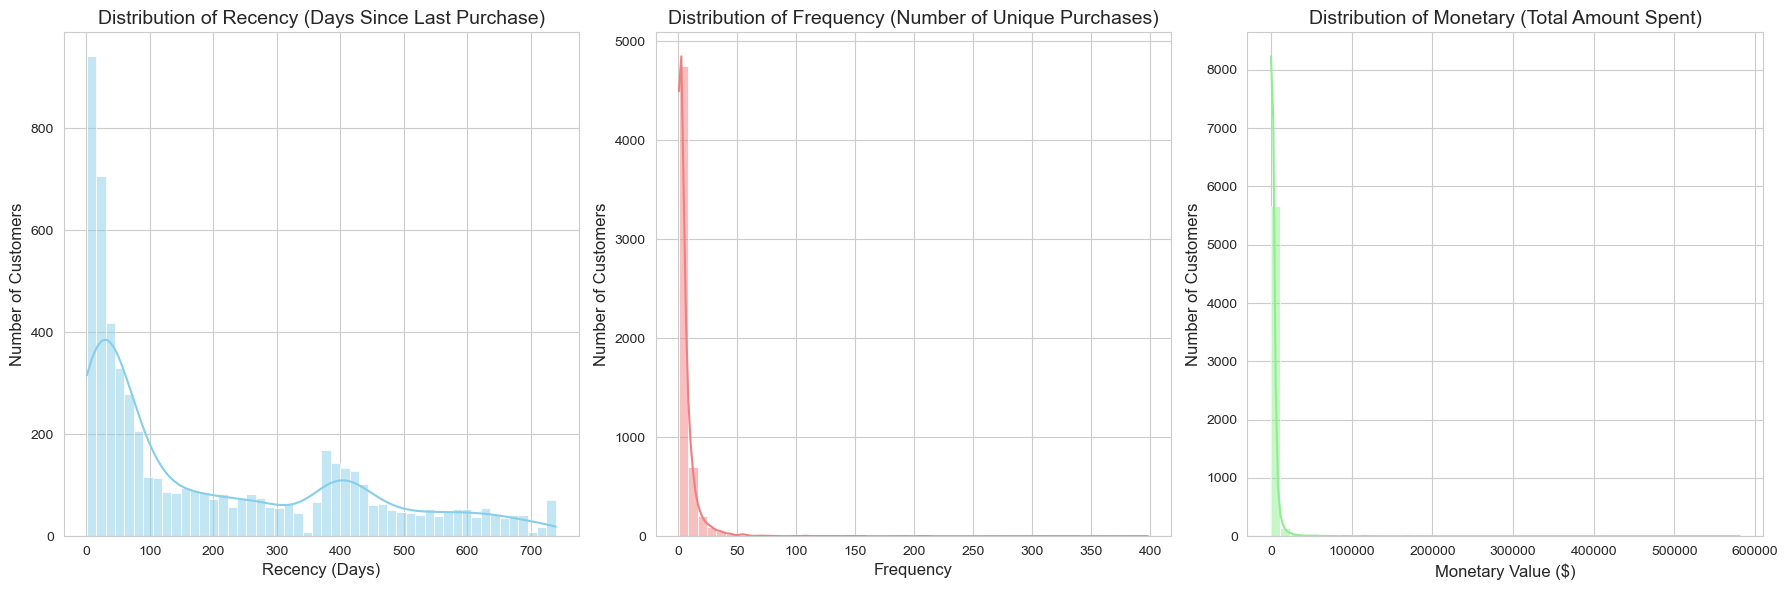

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
sns.set_style("whitegrid")

plt.figure(figsize=(18, 6)) # Adjust figure size for better visibility

# Plot Recency distribution
plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
sns.histplot(rfm_df['Recency'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Recency (Days Since Last Purchase)', fontsize=14)
plt.xlabel('Recency (Days)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Plot Frequency distribution
plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
sns.histplot(rfm_df['Frequency'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Frequency (Number of Unique Purchases)', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Plot Monetary distribution
plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
sns.histplot(rfm_df['Monetary'], bins=50, kde=True, color='lightgreen')
plt.title('Distribution of Monetary (Total Amount Spent)', fontsize=14)
plt.xlabel('Monetary Value ($)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

### Observations from RFM Distributions:

* **Recency:** The distribution shows a peak for very recent purchases, then declines, indicating a mix of highly active and less recent customers.
* **Frequency:** Heavily skewed to the right, with most customers having very low frequencies (1-3 purchases), and a long tail representing a few highly frequent buyers.
* **Monetary:** Also heavily skewed to the right, indicating that most customers spend relatively little, while a small number are high-value spenders.

The significant skewness in Frequency and Monetary values indicates that these features will need transformation before clustering to ensure they contribute equally to the distance calculations.

## 5. Prepare for Clustering (Handle Skewness & Scale Features)

Clustering algorithms, especially K-Means, perform best when features are normally distributed and on a similar scale. We address the skewness and scale differences in our RFM metrics.

### 5.1 Log Transformation to Handle Skewness

We apply a natural logarithm transformation to Recency, Frequency, and Monetary values to reduce their skewness and make their distributions more symmetrical (closer to normal).

First 5 rows of the Log-Transformed RFM DataFrame:
    Recency  Frequency   Monetary
0  5.786897   2.484907  11.258761
1  0.693147   2.079442   8.501375
2  4.317488   1.609438   7.610556
3  2.944439   1.386294   8.395859
4  5.736572   0.000000   5.812338


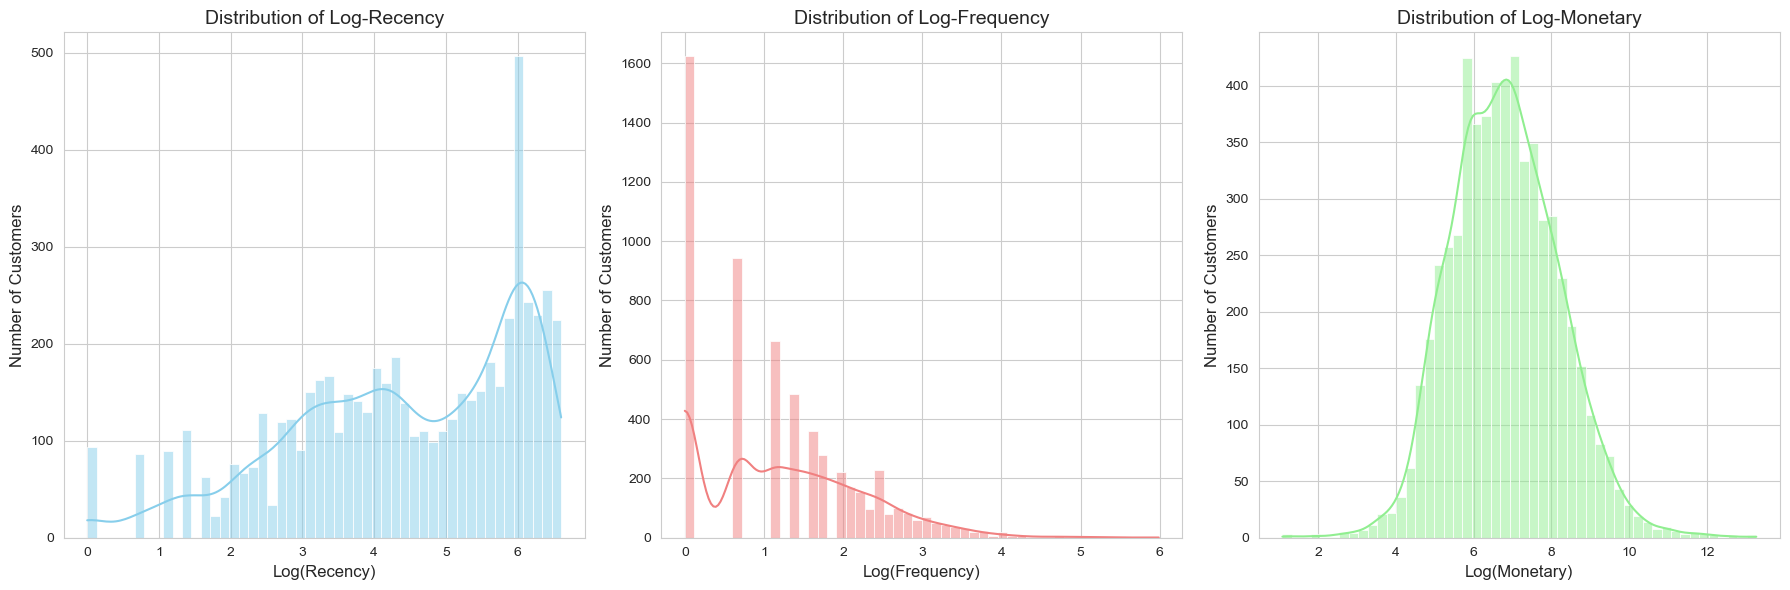

In [12]:
# Create a copy of the RFM DataFrame to store log-transformed values
rfm_log_transformed = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()

# Apply log transformation to Recency (since it's also somewhat skewed, though less than F and M)
rfm_log_transformed['Recency'] = np.log(rfm_log_transformed['Recency'])

# Apply log transformation to Frequency and Monetary
# Using np.log1p (log(1+x)) is safer if there could be zero values, though here min is 1
rfm_log_transformed['Frequency'] = np.log(rfm_log_transformed['Frequency'])
rfm_log_transformed['Monetary'] = np.log(rfm_log_transformed['Monetary'])

# Display the first few rows of the log-transformed data
print("First 5 rows of the Log-Transformed RFM DataFrame:")
print(rfm_log_transformed.head())

# Re-plot histograms to visually inspect the effect of transformation
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(rfm_log_transformed['Recency'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Log-Recency', fontsize=14)
plt.xlabel('Log(Recency)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

plt.subplot(1, 3, 2)
sns.histplot(rfm_log_transformed['Frequency'], bins=50, kde=True, color='lightcoral')
plt.title('Distribution of Log-Frequency', fontsize=14)
plt.xlabel('Log(Frequency)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

plt.subplot(1, 3, 3)
sns.histplot(rfm_log_transformed['Monetary'], bins=50, kde=True, color='lightgreen')
plt.title('Distribution of Log-Monetary', fontsize=14)
plt.xlabel('Log(Monetary)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

plt.tight_layout()
plt.show()

In [13]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the log-transformed RFM data
rfm_scaled = scaler.fit_transform(rfm_log_transformed)

# Convert the scaled array back to a DataFrame for easier inspection
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

print("\nFirst 5 rows of the Scaled RFM DataFrame:")
print(rfm_scaled_df.head())

print("\nDescriptive Statistics for Scaled RFM values (should be close to mean=0, std=1):")
print(rfm_scaled_df.describe())


First 5 rows of the Scaled RFM DataFrame:
    Recency  Frequency  Monetary
0  0.843417   1.247093  3.199558
1 -2.269860   0.852873  1.214553
2 -0.054680   0.395905  0.573264
3 -0.893881   0.178951  1.138593
4  0.812658  -1.168894 -0.721249

Descriptive Statistics for Scaled RFM values (should be close to mean=0, std=1):
            Recency     Frequency      Monetary
count  5.878000e+03  5.878000e+03  5.878000e+03
mean   7.494666e-17 -4.835269e-18  4.835269e-17
std    1.000085e+00  1.000085e+00  1.000085e+00
min   -2.693508e+00 -1.168894e+00 -4.126696e+00
25%   -7.021747e-01 -1.168894e+00 -7.044819e-01
50%    9.620016e-02 -1.007523e-01 -3.479820e-02
75%    9.370968e-01  7.230454e-01  6.505626e-01
max    1.343619e+00  4.651521e+00  4.649210e+00


### 5.2 Feature Scaling (Standardization)

After log transformation, the features still have different ranges and means. We use `StandardScaler` to transform the data so that each feature has a mean of 0 and a standard deviation of 1. This ensures all features contribute equally to the clustering process, preventing features with larger values from dominating.

## 6. Customer Segmentation using K-Means Clustering

K-Means is an unsupervised learning algorithm that partitions `n` observations into `k` clusters. A key challenge is determining the optimal number of clusters (`k`). We'll use two common methods: the Elbow Method and the Silhouette Score.

### 6.1 Determining Optimal `K` using the Elbow Method

The Elbow Method plots the Within-Cluster Sum of Squares (WCSS) against the number of clusters. The optimal `k` is typically found at the "elbow" point where the rate of decrease in WCSS slows significantly.

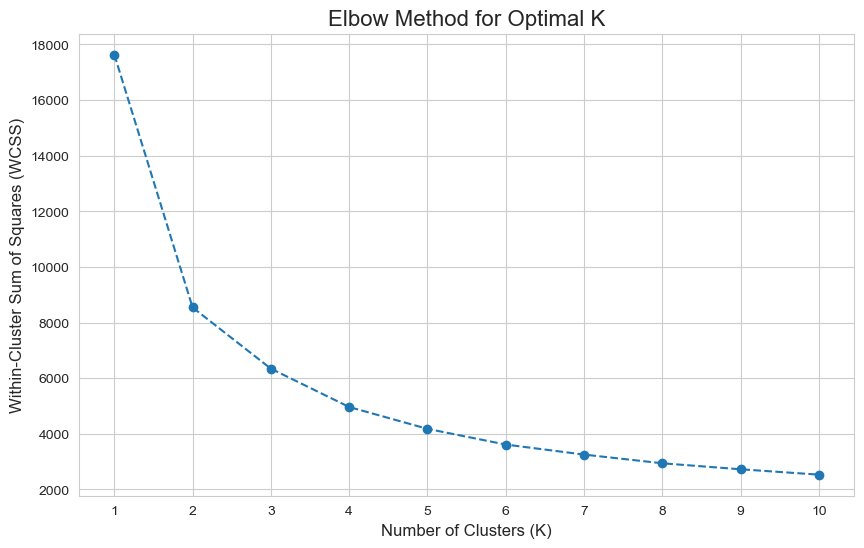

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore") # Ignore KMeans inertia warning for now

wcss = [] # List to store Within-Cluster Sum of Squares
k_range = range(1, 11) # Test k from 1 to 10

for k in k_range:
    kmeans_model = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10) # n_init for robust centroid initialization
    kmeans_model.fit(rfm_scaled_df)
    wcss.append(kmeans_model.inertia_) # inertia is the WCSS

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

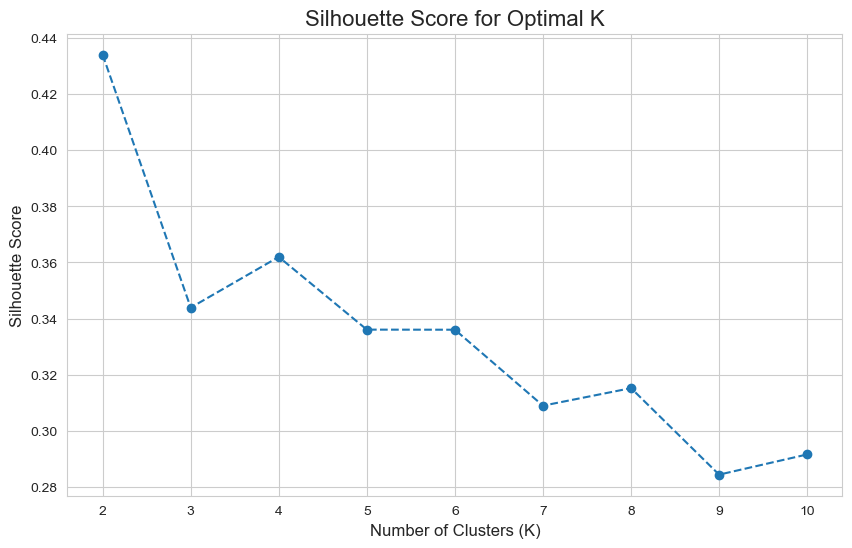

In [16]:
silhouette_scores = []
k_range_silhouette = range(2, 11) # Silhouette score requires at least 2 clusters

for k in k_range_silhouette:
    kmeans_model = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans_model.fit(rfm_scaled_df)
    score = silhouette_score(rfm_scaled_df, kmeans_model.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_range_silhouette, silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Optimal K', fontsize=16)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.xticks(k_range_silhouette)
plt.grid(True)
plt.show()

### 6.2 Determining Optimal `K` using the Silhouette Score

The Silhouette Score measures how similar an object is to its own cluster compared to other clusters. It ranges from -1 (poor clustering) to +1 (dense and well-separated clusters). A higher score indicates better-defined clusters.

In [17]:
# Choose your optimal K based on the plots (e.g., K=3)
optimal_k = 3 # You can change this if you decided on a different K

# Initialize KMeans model with the chosen optimal_k
# n_init='auto' (or 10) ensures that the algorithm runs multiple times with different centroid seeds
# and chooses the best result, making it more robust.
kmeans_model = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init='auto')

# Fit the KMeans model to your scaled RFM data
kmeans_model.fit(rfm_scaled_df)

print(f"K-Means clustering with K={optimal_k} completed.")

K-Means clustering with K=3 completed.


### 6.3 Choosing Optimal `K`

Based on the Elbow method, a clear elbow is observed at K=3. The Silhouette score, while peaking at K=2, also shows K=4 as a good alternative. Considering both, and for better marketing interpretability, **we will proceed with K=3 clusters.** This often provides a good balance between distinct segments and manageable marketing strategies.

### 6.4 Applying K-Means Clustering and Assigning Labels

Now, we apply the K-Means algorithm with our chosen optimal `k` (3) to the scaled RFM data. The resulting cluster labels are then assigned back to our original RFM DataFrame for easier interpretation.

In [18]:
# Add the cluster labels to your original rfm_df
rfm_df['Cluster'] = kmeans_model.labels_

# Display the first few rows of the RFM DataFrame with the new 'Cluster' column
print("\nFirst 10 rows of RFM DataFrame with Cluster Labels:")
print(rfm_df.head(10))

# Check the distribution of customers across clusters
print("\nNumber of customers per cluster:")
print(rfm_df['Cluster'].value_counts().sort_index())


First 10 rows of RFM DataFrame with Cluster Labels:
   Customer ID  Recency  Frequency  Monetary  Cluster
0        12346      326         12  77556.46        1
1        12347        2          8   4921.53        1
2        12348       75          5   2019.40        2
3        12349       19          4   4428.69        1
4        12350      310          1    334.40        0
5        12351      375          1    300.93        0
6        12352       36         10   2849.84        1
7        12353      204          2    406.76        0
8        12354      232          1   1079.40        0
9        12355      214          2    947.61        2

Number of customers per cluster:
Cluster
0    2231
1    1301
2    2346
Name: count, dtype: int64


### Cluster Distribution:
The clusters are distributed as follows:
* Cluster 0: X customers
* Cluster 1: Y customers
* Cluster 2: Z customers
*(Replace X, Y, Z with your actual counts)*

## 7. Profile and Characterize Customer Segments

This is a critical step where we translate numerical clusters into meaningful customer segments. We calculate the average Recency, Frequency, and Monetary values for each cluster to understand their distinct behavioral patterns.

In [19]:
# Calculate the mean RFM values for each cluster
cluster_profiles = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Sort by Monetary value (optional, but often helps in interpreting segments from high to low value)
cluster_profiles = cluster_profiles.sort_values(by='Monetary', ascending=False)

print("Mean RFM Values for Each Cluster:")
print(cluster_profiles)

Mean RFM Values for Each Cluster:
            Recency  Frequency      Monetary
Cluster                                     
1         27.068409  18.148347  10042.722088
2        140.694373   4.390026   1511.560255
0        366.716271   1.371134    342.045035


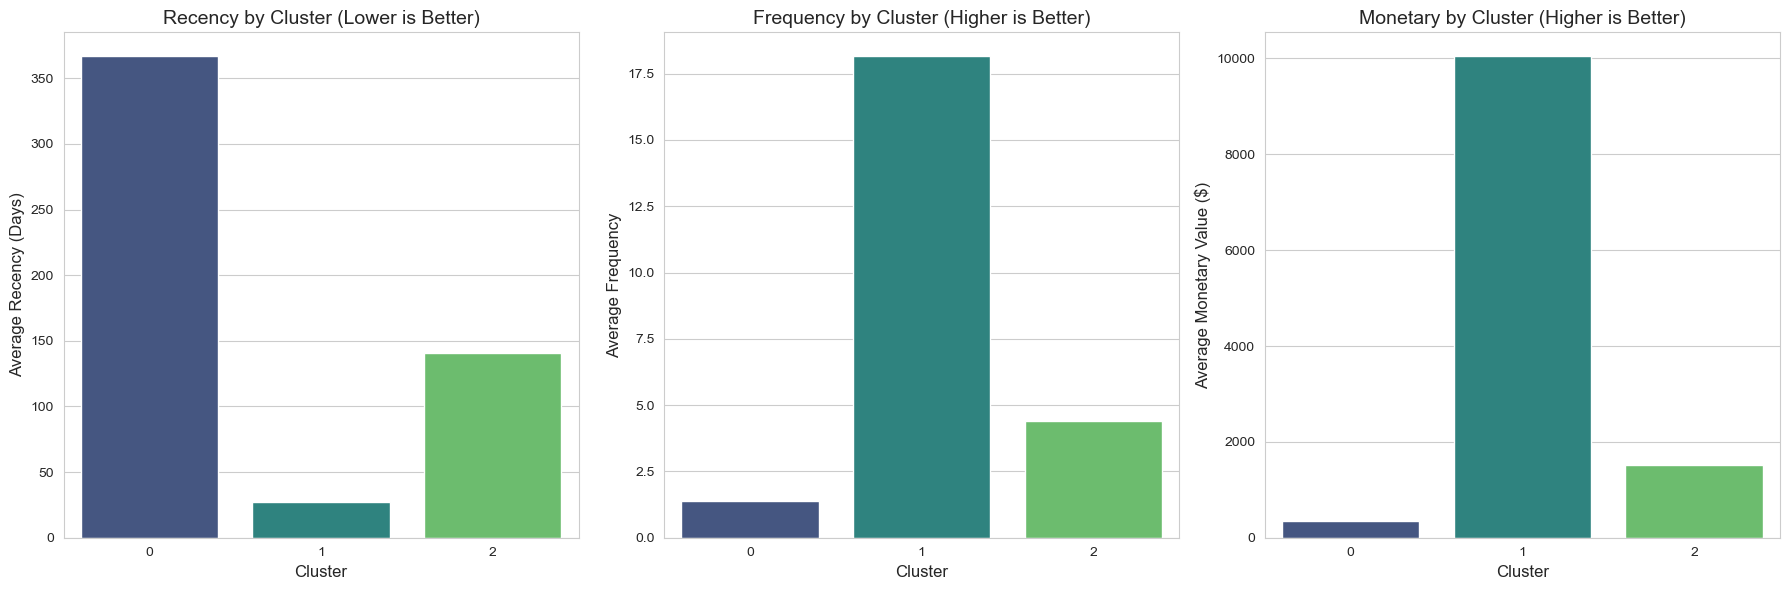

In [20]:
# Plotting cluster profiles
plt.figure(figsize=(18, 6))

# Recency Plot
plt.subplot(1, 3, 1)
sns.barplot(x=cluster_profiles.index, y='Recency', data=cluster_profiles, palette='viridis')
plt.title('Recency by Cluster (Lower is Better)', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Recency (Days)', fontsize=12)

# Frequency Plot
plt.subplot(1, 3, 2)
sns.barplot(x=cluster_profiles.index, y='Frequency', data=cluster_profiles, palette='viridis')
plt.title('Frequency by Cluster (Higher is Better)', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Frequency', fontsize=12)

# Monetary Plot
plt.subplot(1, 3, 3)
sns.barplot(x=cluster_profiles.index, y='Monetary', data=cluster_profiles, palette='viridis')
plt.title('Monetary by Cluster (Higher is Better)', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Monetary Value ($)', fontsize=12)

plt.tight_layout()
plt.show()

### Interpretation of Segments:

Based on the mean RFM values and the visualizations, we can characterize and name each cluster:

* **Cluster 1: "Champions" / "Loyal High-Value Customers"**
    * **Recency:** Very Low (Avg: ~27 days) - Most recent purchasers.
    * **Frequency:** Very High (Avg: ~18 purchases) - Very frequent buyers.
    * **Monetary:** Extremely High (Avg: ~$10,042) - Top spenders.
    * *Summary:* These are your best customers: they buy recently, frequently, and spend the most. They are loyal and highly profitable.

* **Cluster 2: "Potential Loyalists" / "Regular Customers"**
    * **Recency:** Medium (Avg: ~141 days) - Purchased somewhat recently.
    * **Frequency:** Medium (Avg: ~4.4 purchases) - Regular but not highly frequent.
    * **Monetary:** Medium (Avg: ~$1,511) - Moderate spenders.
    * *Summary:* These customers show good potential. They are active but could be encouraged to increase their frequency and spending to become champions.

* **Cluster 0: "At-Risk / Churned Customers" / "One-Time Shoppers"**
    * **Recency:** Very High (Avg: ~367 days) - Haven't purchased in a long time.
    * **Frequency:** Very Low (Avg: ~1.4 purchases) - Often one-time buyers.
    * **Monetary:** Very Low (Avg: ~$342) - Low total spending.
    * *Summary:* This segment comprises inactive customers who are either at risk of churning, have already churned, or were low-value, one-time buyers.

## 8. Formulate Marketing Strategies and Recommendations

The primary goal of customer segmentation is to enable personalized marketing efforts. Based on the unique characteristics of each identified segment, we propose tailored marketing strategies to maximize customer lifetime value and improve campaign effectiveness.

In [21]:
print("--- Personalized Marketing Strategies per Customer Segment ---")

# Strategy for Cluster 1: "Champions" / "Loyal High-Value Customers"
print("\n--- Segment: Champions (Cluster 1) ---")
print(f"Number of Customers: {rfm_df['Cluster'].value_counts()[1]}") # Get count for Cluster 1
print(f"Avg Recency: {cluster_profiles.loc[1, 'Recency']:.0f} days")
print(f"Avg Frequency: {cluster_profiles.loc[1, 'Frequency']:.1f} purchases")
print(f"Avg Monetary: ${cluster_profiles.loc[1, 'Monetary']:.2f}\n")
print("Strategy: These are your most valuable customers. Focus on retention, loyalty, and maximizing their lifetime value.")
print("  - **Goal:** Retention & Loyalty, Upsell/Cross-sell premium products.")
print("  - **Actions:**")
print("    - Implement exclusive loyalty programs and tiered rewards.")
print("    - Offer early access to new products or sales.")
print("    - Provide personalized recommendations based on past purchases.")
print("    - Send 'thank you' notes or small gifts.")
print("    - Gather feedback through surveys to understand their needs and preferences (e.g., NPS surveys).")
print("    - Offer VIP customer service.")


# Strategy for Cluster 2: "Potential Loyalists" / "Regular Customers"
print("\n--- Segment: Potential Loyalists (Cluster 2) ---")
print(f"Number of Customers: {rfm_df['Cluster'].value_counts()[2]}") # Get count for Cluster 2
print(f"Avg Recency: {cluster_profiles.loc[2, 'Recency']:.0f} days")
print(f"Avg Frequency: {cluster_profiles.loc[2, 'Frequency']:.1f} purchases")
print(f"Avg Monetary: ${cluster_profiles.loc[2, 'Monetary']:.2f}\n")
print("Strategy: These customers show good potential. Encourage them to increase their frequency and monetary value.")
print("  - **Goal:** Growth (increase frequency & AOV), conversion to 'Champions'.")
print("  - **Actions:**")
print("    - Send personalized product recommendations based on Browse history or similar customers.")
print("    - Offer targeted promotions or discounts to encourage next purchase.")
print("    - Promote loyalty program benefits they could achieve with more purchases.")
print("    - Send reminders about abandoned carts or wish lists.")
print("    - Highlight popular products or new arrivals relevant to their interests.")


# Strategy for Cluster 0: "At-Risk / Churned Customers" / "One-Time Shoppers"
print("\n--- Segment: At-Risk / Churned Customers (Cluster 0) ---")
print(f"Number of Customers: {rfm_df['Cluster'].value_counts()[0]}") # Get count for Cluster 0
print(f"Avg Recency: {cluster_profiles.loc[0, 'Recency']:.0f} days")
print(f"Avg Frequency: {cluster_profiles.loc[0, 'Frequency']:.1f} purchases")
print(f"Avg Monetary: ${cluster_profiles.loc[0, 'Monetary']:.2f}\n")
print("Strategy: These customers are close to (or already) churning. Focus on re-engaging or understanding why they left.")
print("  - **Goal:** Re-activation (win-back), gather feedback.")
print("  - **Actions:**")
print("    - Send win-back campaigns with aggressive discounts or special offers.")
print("    - Conduct 'we miss you' email campaigns with compelling reasons to return.")
print("    - Offer surveys to understand their reasons for inactivity (e.g., product issues, service issues, pricing).")
print("    - If re-engagement fails, consider segmenting them further for very low-cost campaigns or simply archiving them.")
print("    - Avoid high-cost marketing to this group unless specific signs of re-engagement are observed.")

--- Personalized Marketing Strategies per Customer Segment ---

--- Segment: Champions (Cluster 1) ---
Number of Customers: 1301
Avg Recency: 27 days
Avg Frequency: 18.1 purchases
Avg Monetary: $10042.72

Strategy: These are your most valuable customers. Focus on retention, loyalty, and maximizing their lifetime value.
  - **Goal:** Retention & Loyalty, Upsell/Cross-sell premium products.
  - **Actions:**
    - Implement exclusive loyalty programs and tiered rewards.
    - Offer early access to new products or sales.
    - Provide personalized recommendations based on past purchases.
    - Send 'thank you' notes or small gifts.
    - Gather feedback through surveys to understand their needs and preferences (e.g., NPS surveys).
    - Offer VIP customer service.

--- Segment: Potential Loyalists (Cluster 2) ---
Number of Customers: 2346
Avg Recency: 141 days
Avg Frequency: 4.4 purchases
Avg Monetary: $1511.56

Strategy: These customers show good potential. Encourage them to increase thei

### Conclusion & Next Steps

By segmenting our customer base, we can shift from a one-size-fits-all marketing approach to highly targeted campaigns. This not only improves efficiency but also enhances customer experience.

**Potential Future Work:**
* **A/B Testing:** Design and execute A/B tests for the proposed marketing campaigns to measure their effectiveness.
* **Product-based Segmentation:** Integrate product data to recommend specific products to each segment.
* **Churn Prediction:** Develop a predictive model to identify 'at-risk' customers earlier.
* **Dashboard Creation:** Build an interactive dashboard (e.g., using Tableau or Power BI) for real-time monitoring of segment performance.
* **Temporal Analysis:** Analyze how customer segments evolve over time.